# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


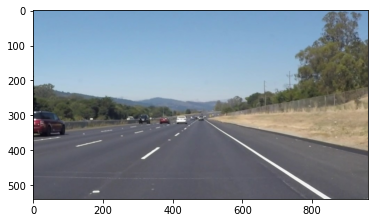

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [10]:

class line_finder:
    def __init__(self):
        self.fit_left_avg_old = np.array([])
        self.fit_right_avg_old = np.array([])

    def fit_coordinate(self, image, fit_parameters):
        slope, intercept = fit_parameters
        y1 = image.shape[0]
        y2 = int(y1*0.6)
        x1 = int((y1-intercept)//slope)
        x2 = int((y2-intercept)//slope)
        return np.array([x1, y1, x2, y2])

    def average_slope_intercept(self, image, lines):
        fit_right = []
        fit_left = []
        fit_left_avg = np.array([])
        fit_right_avg = np.array([])

        # use np.polyfit to find slope and intercept
        for line in lines:
            for x1, y1, x2, y2 in line:
                slope, intercept = np.polyfit((x1, x2), (y1, y2), 1)
                # slope filter
                slope_threthold = 0.4
                if slope > slope_threthold:
                    fit_right.append((slope, intercept))
                elif slope < -slope_threthold:
                    fit_left.append((slope, intercept))
        if fit_left:
            fit_left_avg = np.average(fit_left, axis=0)
        if fit_right:
            fit_right_avg = np.average(fit_right, axis=0)
        # smooth  the move with fit_xx_avg_old
        """ if there's new and old, return avg(new,old) line
            if there's only new, return new line
            if there's only old, return old line
            if there's nothing, return default line
        """
        if (fit_left_avg.size == 0) and self.fit_left_avg_old.size != 0:
            fit_left_avg = self.fit_left_avg_old.copy()
            left_line = self.fit_coordinate(image, fit_left_avg)
        elif fit_left_avg.size != 0:
            if self.fit_left_avg_old.size != 0:
                fit_left_avg = np.average(
                    (fit_left_avg, self.fit_left_avg_old), axis=0, weights=[2, 8])
            self.fit_left_avg_old = fit_left_avg.copy()
            left_line = self.fit_coordinate(image, fit_left_avg)
        else:
            left_line = self.fit_coordinate(image, np.array([-1.0, 700]))

        if fit_right_avg.size == 0 and self.fit_right_avg_old.size != 0:
            fit_right_avg = self.fit_right_avg_old.copy()
            right_line = self.fit_coordinate(image, fit_right_avg)
        elif fit_right_avg.size != 0:
            if self.fit_right_avg_old.size != 0:
                fit_right_avg = np.average(
                    (fit_right_avg, self.fit_right_avg_old), axis=0, weights=[2, 8])
            self.fit_right_avg_old = fit_right_avg.copy()
            right_line = self.fit_coordinate(image, fit_right_avg)
        else:
            right_line = self.fit_coordinate(image, np.array([1.0, 0]))

        return np.array([left_line, right_line])

    def draw_lines(self, lines, image, color, weight):
        for line in lines:
            x1, y1, x2, y2 = line
            cv2.line(image, (x1, y1), (x2, y2), color, weight)
        return image

    def traffic_line(self, image_input):
        # Read in and grayscale the image
        image = image_input
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # Define a kernel size and apply Gaussian smoothing
        kernel_size = 3
        blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

        # Define our parameters for Canny and apply
        low_threshold = 50  # 50
        high_threshold = 180  # 180
        edges = cv2.Canny(blur_gray, low_threshold,
                          high_threshold, L2gradient=True)

        mask = np.zeros_like(edges)
        ignore_color = 255
        imshape = image.shape
        y_high = int(imshape[0]*0.6) + 10
        vertices = np.array([[(0+int(imshape[1]*0.05), int(imshape[0])),
                              (imshape[1]/2 - imshape[1]/16, y_high),
                              (imshape[1]/2 + imshape[1]/16, y_high),
                              (imshape[1]-int(imshape[1]*0.05), int(imshape[0]))]], dtype=np.int32)
        cv2.fillPoly(mask, vertices, ignore_color)
        masked_edges = cv2.bitwise_and(edges, mask)

        # Define the Hough transform parameters
        # Make a blank the same size as our image to draw on
        rho = 1
        theta = (np.pi/180)
        threshold = 20
        min_line_length = 5
        max_line_gap = 3
        line_image = np.copy(image)*0  # creating a blank to draw lines on

        # Run Hough on edge detected image
        lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array(
            []), min_line_length, max_line_gap)

        # ployfit() -- slope,b -- fit_right(+),fit_left(-) -- find points in vertices -- cv2.line
        fit_lines = self.average_slope_intercept(image, lines)

        line_image = self.draw_lines(fit_lines, line_image, (255,0,0), 10) # show traffic line
        # line_image = self.draw_lines([x[0] for x in lines], line_image,(0,255,0), 3) # show Houghline
        # line_image = self.draw_lines((vertices.reshape(2,4)[1],vertices.reshape(2,4)[0]),line_image,(255,255,0), 3) # show vertices

        # Create a "color" binary image to combine with line image
        color_edges = np.dstack((edges, edges, edges))

        # Draw the lines on the edge image
        color_image = True
        if color_image:
            image_output = cv2.addWeighted(
                image, 0.8, line_image, 1, 0)  # color image
        else:
            image_output = cv2.addWeighted(
                color_edges, 0.8, line_image, 1, 0)  # no color image
        return image_output


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

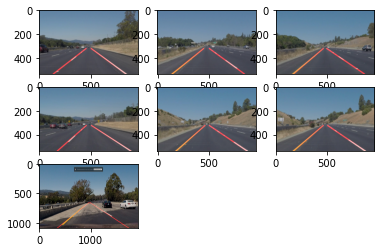

In [11]:
import os
test_images = os.listdir("test_images/")
for i, x in enumerate(test_images):
    image_input = cv2.cvtColor(cv2.imread("test_images/"+x), cv2.COLOR_BGR2RGB)
    image_processing = line_finder()
    image_output = image_processing.traffic_line(image_input)
    plt.subplot(3, 3, i+1)
    plt.imshow(image_output, aspect='auto')
plt.show()

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [17]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
import os
test_images = os.listdir("test_images/")
for i, x in enumerate(test_images):
    image_input = cv2.cvtColor(cv2.imread("test_images/"+x), cv2.COLOR_BGR2RGB)
    image_processing = line_finder()
    image_output = image_processing.traffic_line(image_input)
    cv2.imwrite("test_images_output/"+x+".jpg", cv2.cvtColor(image_output,cv2.COLOR_BGR2RGB))

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return line_finder()

Let's try the one with the solid white lane on the right first ...

In [21]:
for x in [i for i in os.listdir("test_videos/") if i[-3::]=='mp4']:
    white_output = 'test_videos_output/' + x
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
    process_image = line_finder()
    clip1 = VideoFileClip("test_videos/" + x)
    white_clip = clip1.fl_image(process_image.traffic_line) #NOTE: this function expects color images!!
    white_clip.write_videofile(white_output, audio=False)

t:   3%|▎         | 7/221 [00:00<00:03, 67.46it/s, now=None]Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4

t:   0%|          | 0/681 [00:00<?, ?it/s, now=None]Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4

t:   0%|          | 0/251 [00:00<?, ?it/s, now=None]Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4

t: 100%|█████████▉| 250/251 [00:10<00:00, 23.17it/s, now=None]Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4


0

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [45]:
os.system("firefox test_videos_output/*.mp4")



0

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.
